In [15]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None  # Gets rid of the copy warning

# Create the dataframe
df = pd.read_csv('data/mcu_data.csv', skiprows=1)  # Change file to read in here
df

,Title,Year,Actor,US Box Office,International Revenue,Adjusted Revenue,Average Rating,IMDb Rating,Metacritic
0,Iron Man,2008,Robert Downey Jr.,"$319,034,126","$585,796,247","$738,435,213",79.0%,7.9 / 10,79%
1,The Incredible Hulk,2008,Edward Norton,"$134,806,913","$264,770,996","$333,761,488",64.0%,6.7 / 10,61%
2,Iron Man 2,2010,Robert Downey Jr.,"$312,433,331","$623,933,331","$776,412,224",63.5%,7.0 / 10,57%
3,Thor,2011,Chris Hemsworth,"$181,030,624","$449,326,618","$542,228,742",63.5%,7 / 10,57%
4,Captain America: The First Avenger,2011,Chris Evans,"$176,654,505","$370,569,774","$447,188,247",67.5%,6.9 / 10,66%
5,The Avengers,2012,Robert Downey Jr.,"$623,357,910","$1,518,815,515","$1,795,324,611",74.5%,8.0 / 10,69%
6,Iron Man 3,2013,Robert Downey Jr.,"$409,013,994","$1,214,811,252","$1,415,020,488",66.5%,7.1 / 10,62%
7,Thor: The Dark World,2013,Chris Hemsworth,"$206,362,140","$644,783,140","$751,047,829",61.5%,6.9 / 10,54%
8,Captain America: The Winter Soldier,2014,Chris Evans,"$259,766,572","$714,421,503","$819,155,031",73.5%,7.7 / 10,70%
9,Guardians of the Galaxy,2014,Chris Pratt,"$333,718,600","$773,350,147","$886,722,560",78.0%,8.0 / 10,76%


In [16]:
# Turn all numeric columns from formatted strings into floats
df['Adjusted Revenue'] = df['Adjusted Revenue'].apply(lambda x:  1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['US Box Office'] = df['US Box Office'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','')))
df['International Revenue'] = df['International Revenue'].apply(lambda x: 1 if x == 'No Data'  else float(x.replace(',', '').replace('$','').strip(' (est.)')))
df['Average Rating'] = df['Average Rating'].apply(lambda x: float(x.replace('%', '')))
df['Metacritic'] = df['Metacritic'].apply(lambda x: float(x.replace('%', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: float(x.replace(' / 10', '').replace(' (est.)', '')))
df['IMDb Rating'] = df['IMDb Rating'].apply(lambda x: x*10)


In [17]:
# Fill in 'No Data' entries with mean for column
for index, row in df.iterrows():
    if df['Adjusted Revenue'][index] == 1:
        df['Adjusted Revenue'][index] = df['Adjusted Revenue'].mean()
    if df['US Box Office'][index] == 1:
        df['US Box Office'][index] = df['US Box Office'].mean()
    if df['International Revenue'][index] == 1:
        df['International Revenue'][index] = df['International Revenue'].mean()

The franchines has seen review scores improve over time


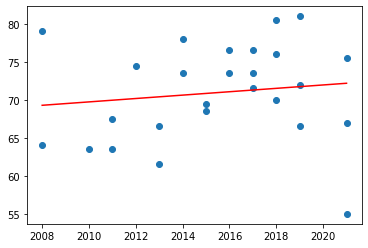

In [18]:
# Create the Average Review Score Plot
x = df['Year'].tolist()
y = df['Average Rating'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen review scores improve over time')
elif z[0] < -0.05:
    print('The franchise has seen review scores decline over time')
else:
    print('The franchise has maintained a consistent quality over time')
plt.show()

The franchines has seen revenue increase over time


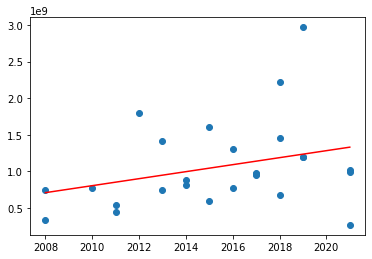

In [19]:
# Create the Revenue Plot
x = df['Year'].tolist()
y = df['Adjusted Revenue'].tolist()
plt.scatter(x, y)

# Create the Trendline
z = np.polyfit(x, y, 1)  # Gets values for trendline equation 
p = np.poly1d(z)  # Creates the trendline equation
plt.plot(x,p(x), color = 'red')

# Display the results
if z[0] > 0.05:
    print('The franchines has seen revenue increase over time')
elif z[0] < -0.05:
    print('The franchise has seen revenue decrease over time')
else:
    print('The franchise has maintained a consistent revenue over time')
plt.show()

In [20]:
# Use qcut() to put adjusted revenue and Average Rating into 3 groups 
df['Rating Category'] = pd.qcut(df['Average Rating'], q=3, labels=False)
df['Revenue Category'] = pd.qcut(df['Adjusted Revenue'], q=3, labels=False)

# Change qcut numbers to qualatative categories
bin = {
    0: 'Low',
    1: 'Average',
    2: 'High'
}
#df['Rating Category'] = df['Rating Category'].map(bin)  # Both map() and apply() do the same thing with different syntax
#df['Revenue Category'] = df['Revenue Category'].apply(lambda x: 'Low' if x == 0 else ('Average' if x == 1 else 'High'))
#df = pd.get_dummies(df, columns=['Rating Category'], prefix = ['Rating'])
df

,Title,Year,Actor,US Box Office,International Revenue,Adjusted Revenue,Average Rating,IMDb Rating,Metacritic,Rating Category,Revenue Category
0,Iron Man,2008,Robert Downey Jr.,3.190341e+08,5.857962e+08,7.384352e+08,79.0,79.0,79.0,2,0
1,The Incredible Hulk,2008,Edward Norton,1.348069e+08,2.647710e+08,3.337615e+08,64.0,67.0,61.0,0,0
2,Iron Man 2,2010,Robert Downey Jr.,3.124333e+08,6.239333e+08,7.764122e+08,63.5,70.0,57.0,0,1
3,Thor,2011,Chris Hemsworth,1.810306e+08,4.493266e+08,5.422287e+08,63.5,70.0,57.0,0,0
4,Captain America: The First Avenger,2011,Chris Evans,1.766545e+08,3.705698e+08,4.471882e+08,67.5,69.0,66.0,0,0
5,The Avengers,2012,Robert Downey Jr.,6.233579e+08,1.518816e+09,1.795325e+09,74.5,80.0,69.0,2,2
6,Iron Man 3,2013,Robert Downey Jr.,4.090140e+08,1.214811e+09,1.415020e+09,66.5,71.0,62.0,0,2
7,Thor: The Dark World,2013,Chris Hemsworth,2.063621e+08,6.447831e+08,7.510478e+08,61.5,69.0,54.0,0,0
8,Captain America: The Winter Soldier,2014,Chris Evans,2.597666e+08,7.144215e+08,8.191550e+08,73.5,77.0,70.0,1,1
9,Guardians of the Galaxy,2014,Chris Pratt,3.337186e+08,7.733501e+08,8.867226e+08,78.0,80.0,76.0,2,1


In [21]:
# Set X and Y for the training set
y = df['Revenue Category']
X = df.drop(['Title', 'Actor', 'Revenue Category'], axis=1)

In [22]:
# Build the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [23]:
# Create the KNN model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Make predictions for 'Rating Category' and 'Revenue Category'
y_pred = knn.predict(X_test)

# Print the Accuracy score
from sklearn.metrics import accuracy_score
print('Accuracy: '+ str(accuracy_score(y_test, y_pred)))

Accuracy: 0.8571428571428571


In [24]:
# Create a DTC model
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train, y_train)

# Make the Prediction for 'Revenue Category'
y_pred2 = clf.predict(X_test)

# Print the results
print('Accuracy: '+str(accuracy_score(y_test, y_pred2)))

Accuracy: 0.7142857142857143


In [25]:
# Use 1-hot encoding for the categorical features created by qcut()
df = pd.get_dummies(df, columns=['Rating Category'], prefix = ['Rating'])
df = pd.get_dummies(df, columns=['Revenue Category'], prefix = ['Revenue'])
df = df.reindex(columns = ['Title', 'Year', 'Adjusted Revenue', 'Revenue_Low', 'Revenue_Average', 'Revenue_High', 'Average Rating', 'Rating_Low', 'Rating_Average', 'Rating_High'])

In [26]:
# Scale the 1-hot encoded columns
# from sklearn.preprocessing import StandardScaler
# df = df.drop(columns=['Title'])
# std_scaler = StandardScaler()
# data_scaled = std_scaler.fit_transform(df)